In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import wfdb    
import os
from scipy.signal import butter, filtfilt

In [11]:
def filter(ecg_signal, sampling_rate):
    # Bandpass
    low = 0.5 / (0.5 * sampling_rate)
    high = 20 / (0.5 * sampling_rate)
    b, a = butter(4, [low, high], btype='band')
    filtered_ecg = filtfilt(b, a, ecg_signal)
    # mean = np.mean(filtered_ecg)
    # std = np.std(filtered_ecg)
    # standardized_data = (filtered_ecg - mean) / std
    return filtered_ecg

In [12]:
data_dir = 'ludb/1.0.1/data/'
data_path = '../lobachevsky-university-electrocardiography-database-1.0.1/data/'
fs = 500

# Get all records
records = [f.split('.')[0] for f in os.listdir(data_path) if f.endswith('.dat')]
records = sorted(records)

# Read the ludb rhythm data
ludb_df = pd.read_csv('../lobachevsky-university-electrocardiography-database-1.0.1/ludb.csv', header=None)

# Create a dictionary to map record names to their rhythms
record_to_rhythm = {row[0]: row[3] for index, row in ludb_df.iterrows()}

#print(df[0][0])

dfs = []  # List to store individual dataframes

for i, record_name in enumerate(records):
    # Read the ECG record
    record = wfdb.rdrecord(record_name, pn_dir=data_dir)
    # Ensure signal is long enough to be trimmed
    #if record.p_signal.shape[0] >= 5000:  # Assuming the signals are at least 5000 samples long
    # Trim the signal to 3000 samples in length by removing the first 1000 and last 1000 samples
    trimmed_signal = record.p_signal

    # Convert the trimmed signal for lead ii to a DataFrame
    lead_i_idx = record.sig_name.index('ii')
    df_signals = pd.DataFrame({'ii': trimmed_signal[:, lead_i_idx]})

    # Read the annotations for lead ii
    annotations = wfdb.rdann(record_name, 'ii', pn_dir=data_dir)

    # Filter annotations to include only those that fall within the trimmed range
    # valid_annotations = [(index-1000, symbol) for index, symbol in zip(annotations.sample, annotations.symbol)
    #                         if 1000 <= index < record.p_signal.shape[0]-1000]
    valid_annotations = [(index, symbol) for index, symbol in zip(annotations.sample, annotations.symbol)]

    # Create a column for the lead ii annotations and fill with 0
    df_signals['target'] = 0

    # Initialize flags for the presence of annotations 'N', 'p', 't'
    has_N, has_p, has_t = False, False, False

    # Apply valid annotations to the DataFrame
    for index, symbol in valid_annotations:
        if symbol == 'N':
            df_signals.at[index, 'target'] = 3
            has_N = True
        elif symbol == 'p':
            df_signals.at[index, 'target'] = 1
            has_p = True
        elif symbol == 't':
            df_signals.at[index, 'target'] = 5
            has_t = True



    rhythm = record_to_rhythm.get(record_name, 'Unknown')
    # Check if all three annotations are present
    if has_N and has_p and has_t or rhythm == "Atrial fibrillation":
        # Add a column to identify the record
        df_signals.insert(0, 'record', record_name)

        # Retrieve the rhythm for the current record and add it as a new column

        df_signals['rhythm'] = rhythm

        # Append this DataFrame to the list
        dfs.append(df_signals)

# Concatenate all DataFrames into one
df_filtered = pd.concat(dfs, ignore_index=True)



In [26]:
# df_all = pd.read_csv('ludb_data.csv', header=None)

df = df_filtered.loc[df_filtered.iloc[:, 3] == 'Sinus rhythm']

# Assuming each signal has 5000 entries
signal_length = 5000

# Calculate the number of signals
num_signals = df.shape[0] // signal_length

# Extract the signal values and target values without column names
signals = df.iloc[:num_signals * signal_length, 1].to_numpy().reshape(-1, signal_length)
targets = df.iloc[:num_signals * signal_length, 2].to_numpy().reshape(-1, signal_length)

# SHorten real data to desired length
signals = signals[:136]
targets = targets[:136]

In [14]:
def standarize(signal):
    mean = np.mean(signal)
    std = np.std(signal)
    standardized_data = (signal - mean) / std
    return standardized_data

In [15]:
from add_qs import add_qs_peaks_modified
targets=add_qs_peaks_modified(signals,targets)

1


ValueError: x and y must have same first dimension, but have shapes (3000,) and (5000,)

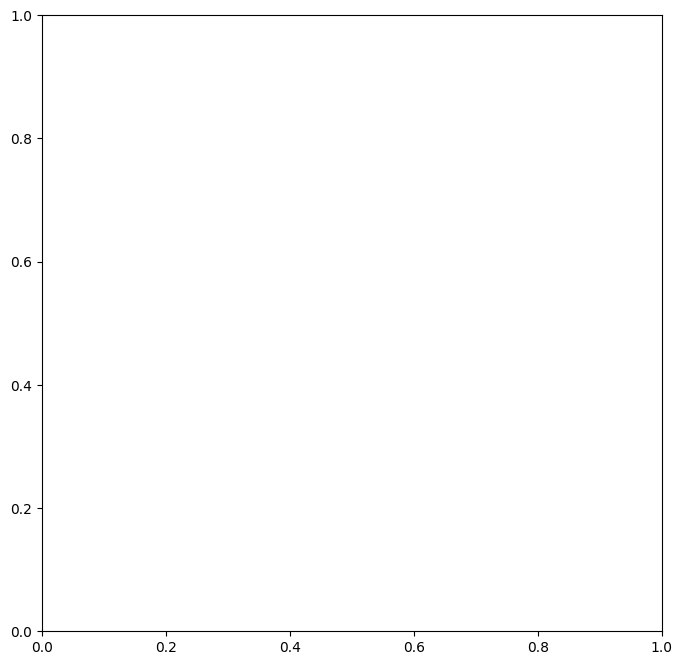

In [16]:
i=1
    
indices = np.array(range(3000))/500
plt.figure(1, figsize=(8, 8))

print(i)
signal = standarize(signals[i])

#signal = np.transpose(sample[0])

predicted_p = np.where(targets[i] == 1)
predicted_q = np.where(targets[i] == 2)
predicted_r = np.where(targets[i] == 3)
predicted_s = np.where(targets[i] == 4)
predicted_t = np.where(targets[i] == 5)

plt.plot(indices, signal)
plt.scatter(indices[predicted_p], signal[predicted_p], marker='D', s=20, color='green', label='P-wave')
plt.scatter(indices[predicted_q], signal[predicted_q], marker='D', s=20, color='orange', label='Q-wave')
plt.scatter(indices[predicted_r], signal[predicted_r], marker='D', s=20, color='red', label='R-wave')
plt.scatter(indices[predicted_s], signal[predicted_s], marker='D', s=20, color='blue', label='S-wave')
plt.scatter(indices[predicted_t], signal[predicted_t], marker='D', s=20, color='fuchsia', label='T-wave')

plt.grid(True, which='major', axis='both', linestyle='-', color='gray')
plt.minorticks_on()
plt.grid(True, which='minor', axis='both', linestyle='--', color='lightgray')

# Set the x-axis major tick marks to appear every 1 ms
plt.xticks(np.arange(0, 10, 1))
#plt.ylim(-8, 8)
plt.xlim(0, 6)

#plt.title('Predictions', y=0.93)
#plt.xlabel('Time in seconds')
#plt.legend(loc="lower right")
plt.show()

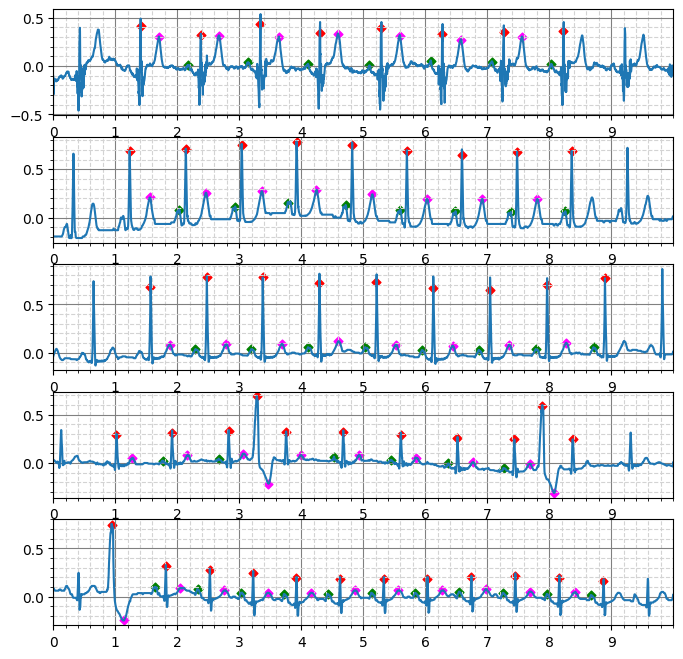

In [29]:
# from ECG_signal_generator import dataset
# t, signals, targets = dataset(5, False)
indices = np.array(range(5000))/500
plt.figure(1, figsize=(8, 8))

for i in range(5):
    signal = signals[i]
    
    #signal = np.transpose(sample[0])
    
    predicted_p = np.where(targets[i] == 1)
    predicted_q = np.where(targets[i] == 2)
    predicted_r = np.where(targets[i] == 3)
    predicted_s = np.where(targets[i] == 4)
    predicted_t = np.where(targets[i] == 5)
    
    plt.subplot(5, 1, i + 1)
    plt.plot(indices, signal)
    plt.scatter(indices[predicted_p], signal[predicted_p], marker='D', s=20, color='green', label='P-wave')
    plt.scatter(indices[predicted_q], signal[predicted_q], marker='D', s=20, color='orange', label='Q-wave')
    plt.scatter(indices[predicted_r], signal[predicted_r], marker='D', s=20, color='red', label='R-wave')
    plt.scatter(indices[predicted_s], signal[predicted_s], marker='D', s=20, color='blue', label='S-wave')
    plt.scatter(indices[predicted_t], signal[predicted_t], marker='D', s=20, color='fuchsia', label='T-wave')

    plt.grid(True, which='major', axis='both', linestyle='-', color='gray')
    plt.minorticks_on()
    plt.grid(True, which='minor', axis='both', linestyle='--', color='lightgray')
    
    # Set the x-axis major tick marks to appear every 1 ms
    plt.xticks(np.arange(0, 10, 1))
    #plt.ylim(-0., 0.4)
    plt.xlim(0, 10)

#plt.title('Predictions', y=0.93)
#plt.xlabel('Time in seconds')
#plt.legend(loc="lower right")
plt.show()